In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eu9h1w9s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eu9h1w9s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=41f1d7a7d8296646cd68cb9b62286b19d7d38a701fc53b5e738c461589758790
  Stored in directory: /tmp/pip-ephem-wheel-cache-19fejxxk/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import torch
import clip
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.linalg import orthogonal_procrustes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Loading CLIP on {device}...")

Loading CLIP on cuda...


In [ ]:
#loading clip model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

#loading stl-10 dataset
print("Loading STL-10 dataset")
dataset = STL10(root="./data", split="test", download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
print(f"Classes: {class_names}")

#defining prompt strategies
prompt_templates = {
  "Plain": lambda c: f"{c}",
  "Standard": lambda c: f"a photo of a {c}",
  "Descriptive": lambda c: f"a high resolution photo of a {c} in the wild"
}

#evaluation function
def evaluate_strategy(strategy_name, prompt_func):

  print(f"\nTesting {strategy_name}")

  #encoding text prompts
  texts = [prompt_func(c) for c in class_names]
  text_inputs = clip.tokenize(texts).to(device)

  with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

  #classifying images
  correct = 0
  total = 0

  for images, labels in tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      image_features = clip_model.encode_image(images)
      image_features /= image_features.norm(dim=-1, keepdim=True)

      #calculating similarity
      similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

      #getting predictions
      values, indices = similarity.topk(1, dim=-1)
      predicted = indices.squeeze()

      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  accuracy = 100 * correct / total
  print(f"Accuracy: {accuracy:.2f}%")

  return accuracy

#running experiments
results = {}

for strategy_name, prompt_func in prompt_templates.items():
  accuracy = evaluate_strategy(strategy_name, prompt_func)
  results[strategy_name] = accuracy

#printing results
print("\nFinal Results:")
for strategy_name, accuracy in results.items():
  print(f"{strategy_name}: {accuracy:.2f}%")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 181MiB/s]


Loading STL-10 dataset


100%|██████████| 2.64G/2.64G [00:51<00:00, 51.4MB/s]


Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Testing Plain


100%|██████████| 250/250 [00:26<00:00,  9.60it/s]


Accuracy: 96.26%

Testing Standard


100%|██████████| 250/250 [00:25<00:00,  9.97it/s]


Accuracy: 97.36%

Testing Descriptive


100%|██████████| 250/250 [00:25<00:00,  9.92it/s]

Accuracy: 97.06%

Final Results:
Plain: 96.26%
Standard: 97.36%
Descriptive: 97.06%


Exploring the Modality Gap

Extracting features


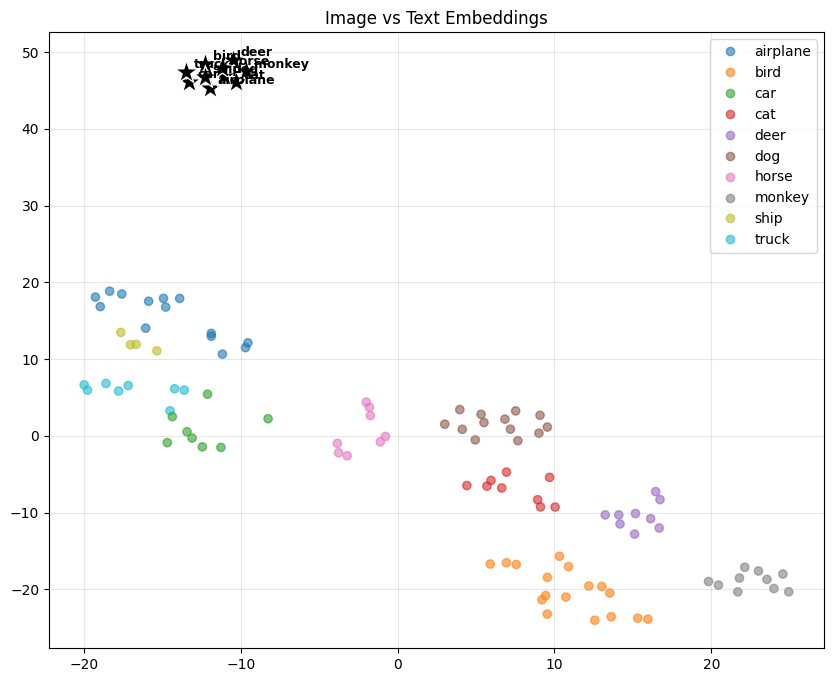

In [ ]:
#loading clip model
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

#loading stl-10 dataset
dataset = STL10(root="./data", split="test", download=True, transform=preprocess)
subset_indices = range(100)
subset = torch.utils.data.Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=100, shuffle=False)

#extracting features
print("Extracting features")

images, labels = next(iter(dataloader))
images = images.to(device)

#encoding images
with torch.no_grad():
  image_features = clip_model.encode_image(images)
  image_features /= image_features.norm(dim=-1, keepdim=True)

#encoding text prompts
class_names = dataset.classes
text_prompts = [f"a photo of a {c}" for c in class_names]
text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
  text_features = clip_model.encode_text(text_inputs)
  text_features /= text_features.norm(dim=-1, keepdim=True)

#combining features
all_features = torch.cat([image_features, text_features], dim=0).cpu().numpy()

#running tsne
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedded = tsne.fit_transform(all_features)

#splitting embeddings
image_embeddings = embedded[:100]
text_embeddings = embedded[100:]

#plotting
plt.figure(figsize=(10, 8))

scatter = plt.scatter(image_embeddings[:, 0], image_embeddings[:, 1],
                     c=labels, cmap='tab10', alpha=0.6, label='Images')

for i, text_loc in enumerate(text_embeddings):
  plt.scatter(text_loc[0], text_loc[1], marker='*', s=300, c='black', edgecolors='white')
  plt.text(text_loc[0]+0.5, text_loc[1]+0.5, class_names[i], fontsize=9, weight='bold')

plt.title("Image vs Text Embeddings")
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.grid(True, alpha=0.3)
plt.savefig('clip_modality_gap.png')
plt.show()

Bridging the Modality Gap

Extracting features for alignment
Solving orthogonal procrustes
Running t-SNE on aligned features


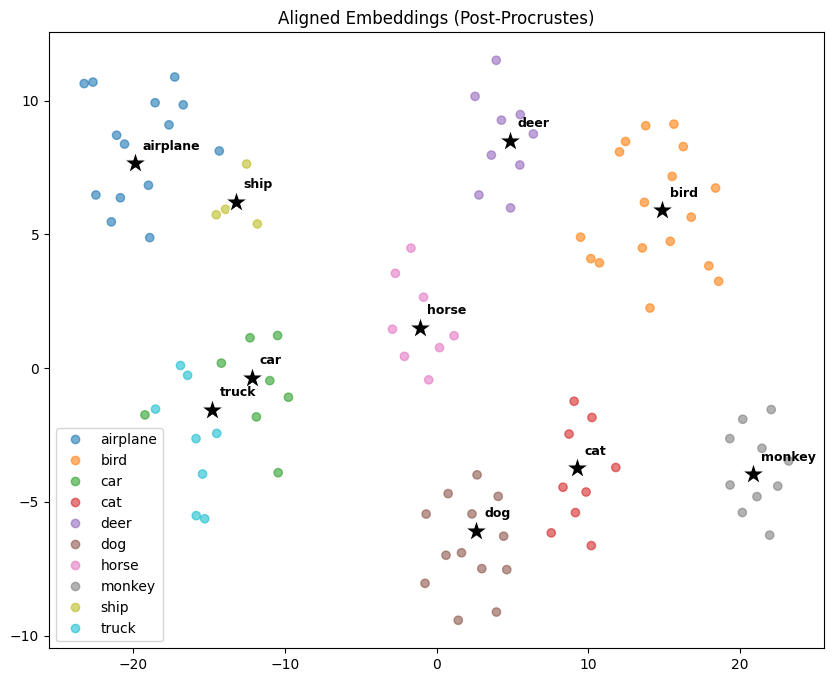


Evaluating aligned features
Accuracy with alignment: 98.00%


In [ ]:
#loading clip model
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

#loading stl-10 dataset
dataset = STL10(root="./data", split="test", download=True, transform=preprocess)
subset_indices = range(500)
subset = torch.utils.data.Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=100, shuffle=False)

class_names = dataset.classes

#extracting paired embeddings
image_embeddings_list = []
text_embeddings_list = []
labels_list = []

print("Extracting features for alignment")

#encoding all class text prompts
text_prompts = [f"a photo of a {c}" for c in class_names]
text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
  all_text_features = clip_model.encode_text(text_inputs)
  all_text_features /= all_text_features.norm(dim=-1, keepdim=True)

for images, labels in dataloader:
  images = images.to(device)
  labels = labels.to(device)

  with torch.no_grad():
    #encoding images
    image_features = clip_model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    #getting corresponding text features
    text_features = all_text_features[labels]

    image_embeddings_list.append(image_features.cpu().numpy())
    text_embeddings_list.append(text_features.cpu().numpy())
    labels_list.append(labels.cpu().numpy())

image_embeddings = np.concatenate(image_embeddings_list, axis=0)
text_embeddings = np.concatenate(text_embeddings_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

#solving procrustes problem
print("Solving orthogonal procrustes")
rotation_matrix, scale = orthogonal_procrustes(image_embeddings, text_embeddings)

#applying alignment
aligned_embeddings = image_embeddings @ rotation_matrix

#visualizing aligned features
print("Running t-SNE on aligned features")

viz_images = aligned_embeddings[:100]
viz_texts = all_text_features.cpu().numpy()
viz_labels = labels_array[:100]

combined = np.concatenate([viz_images, viz_texts], axis=0)

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedded = tsne.fit_transform(combined)

image_embeddings_2d = embedded[:100]
text_embeddings_2d = embedded[100:]

#plotting
plt.figure(figsize=(10, 8))

scatter = plt.scatter(image_embeddings_2d[:, 0], image_embeddings_2d[:, 1],
                     c=viz_labels, cmap='tab10', alpha=0.6)

for i, text_loc in enumerate(text_embeddings_2d):
  plt.scatter(text_loc[0], text_loc[1], marker='*', s=300, c='black', edgecolors='white')
  plt.text(text_loc[0]+0.5, text_loc[1]+0.5, class_names[i], fontsize=9, weight='bold')

plt.title("Aligned Embeddings (Post-Procrustes)")
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.savefig('procrustes_alignment.png')
plt.show()

#evaluating accuracy
print("\nEvaluating aligned features")

aligned_tensor = torch.tensor(aligned_embeddings).to(device)
logits = 100.0 * aligned_tensor.to(all_text_features.dtype) @ all_text_features.T
predictions = logits.argmax(dim=-1).cpu().numpy()

accuracy = (predictions == labels_array).mean() * 100
print(f"Accuracy with alignment: {accuracy:.2f}%")